### Semantic Segmentation

In [3]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

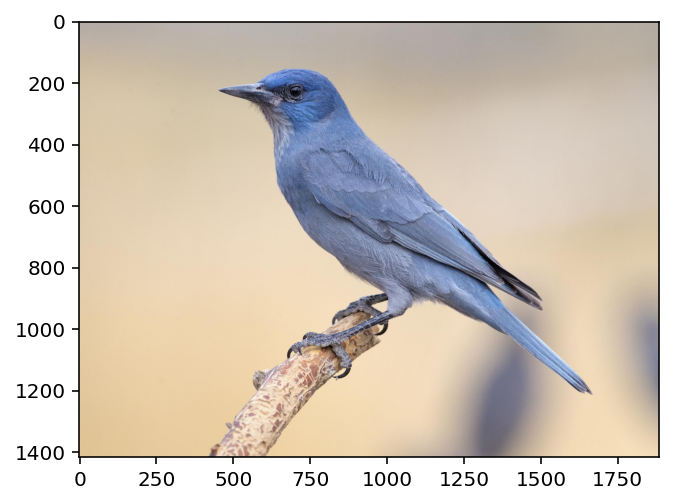

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

img = Image.open('./bird.png')
plt.imshow(img); plt.show()

In [5]:
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0) # batchsize 후 모습 만들기
inp.shape

torch.Size([1, 3, 224, 224])

Model Description
FCN-ResNet101 is constructed by a Fully-Convolutional Network model with a ResNet-101 backbone. The pre-trained models have been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.

Their accuracies of the pre-trained models evaluated on COCO val2017 dataset are listed below.

In [39]:
# Pass the input through the net
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 224, 224])


<class 'numpy.ndarray'> (1, 21, 224, 224)
<class 'numpy.ndarray'> (21, 224, 224)


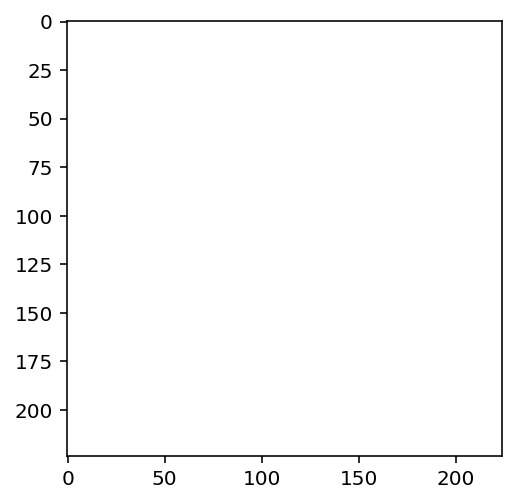

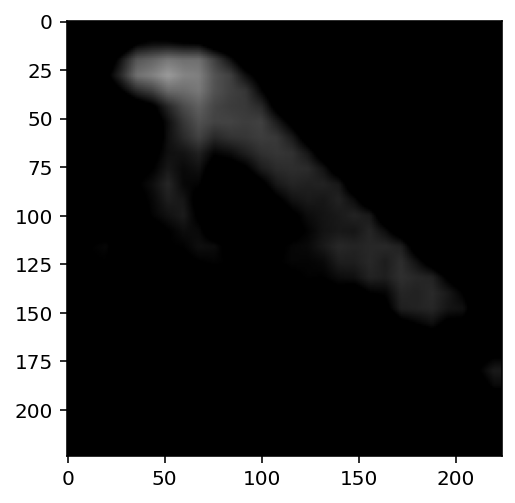

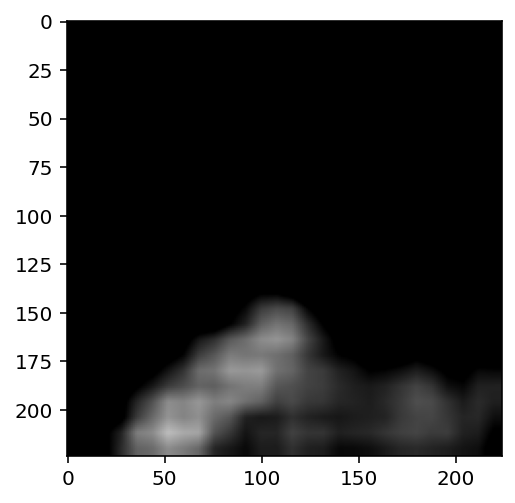

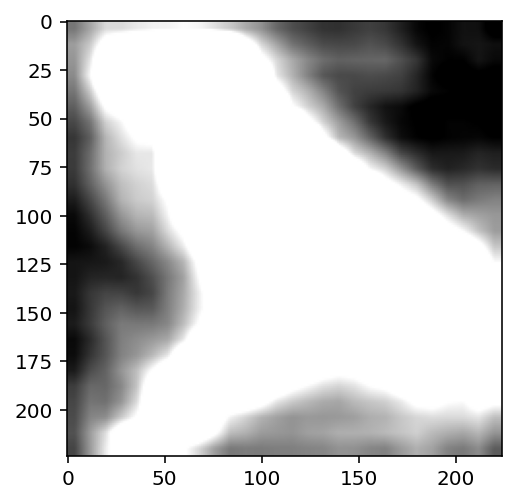

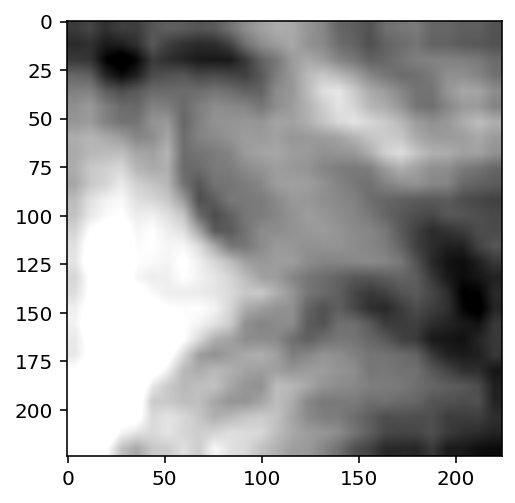

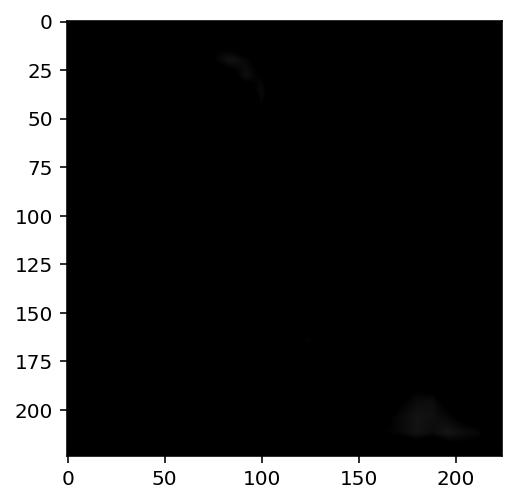

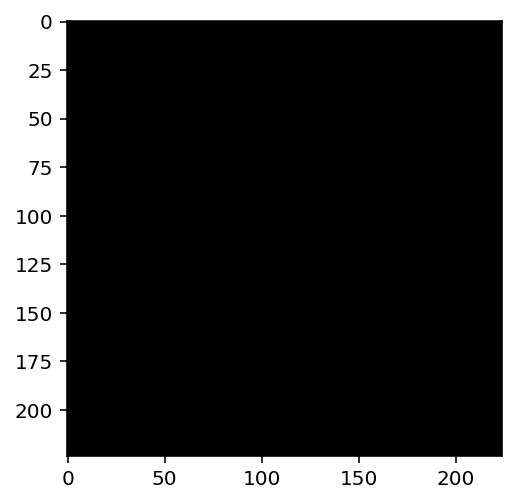

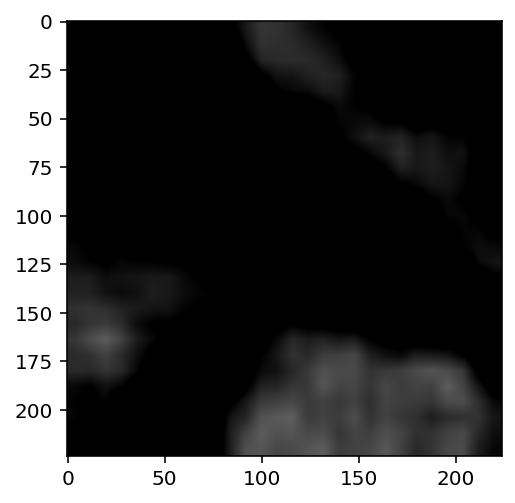

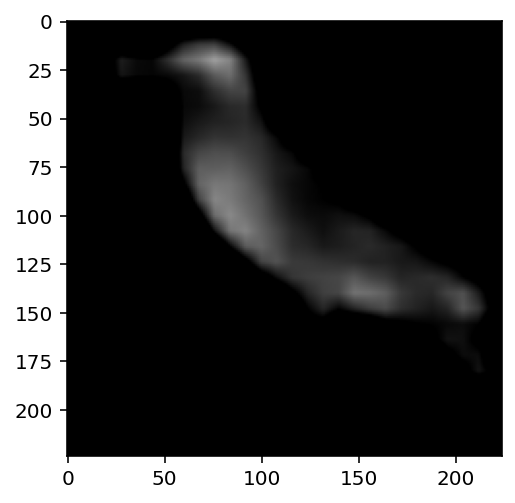

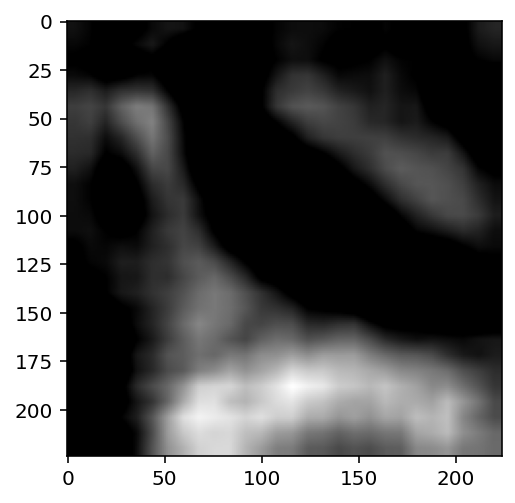

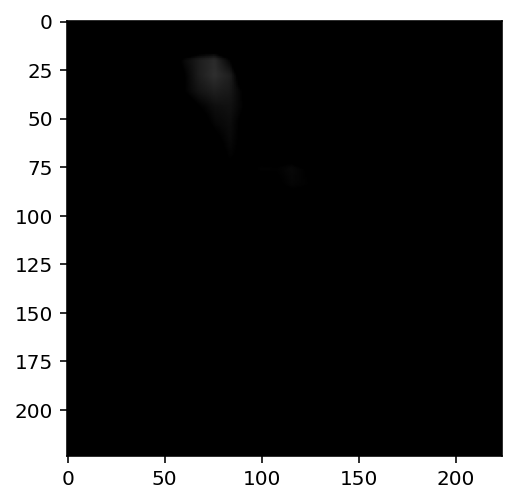

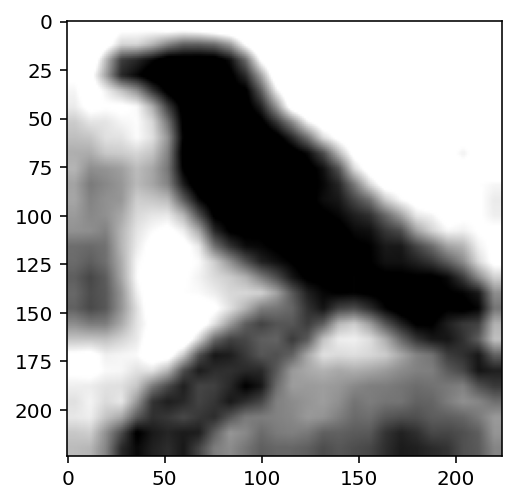

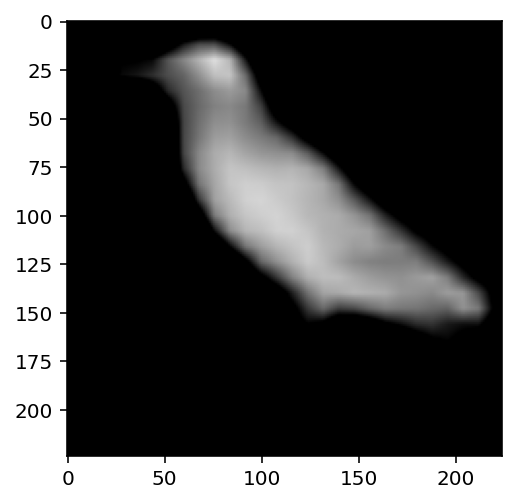

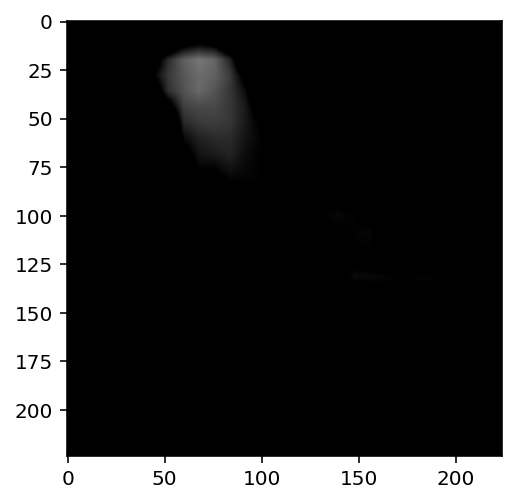

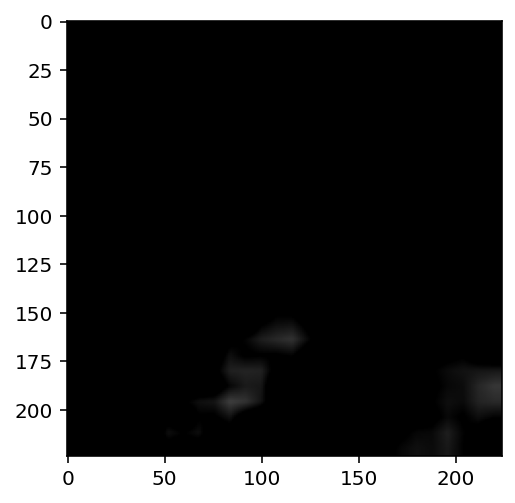

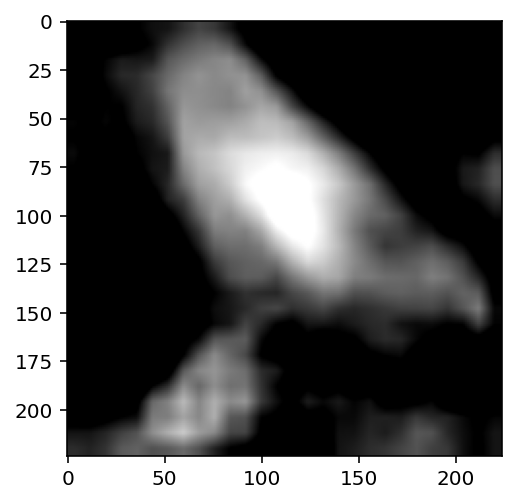

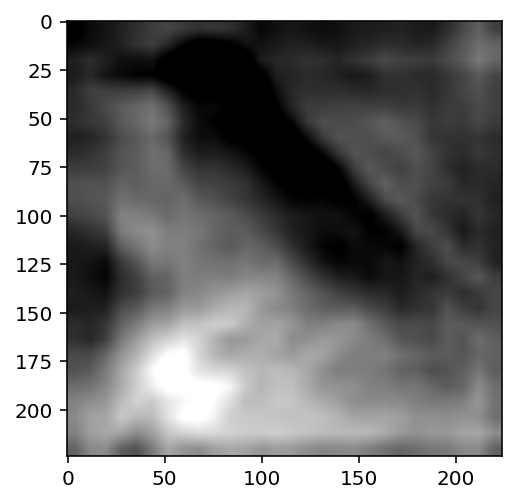

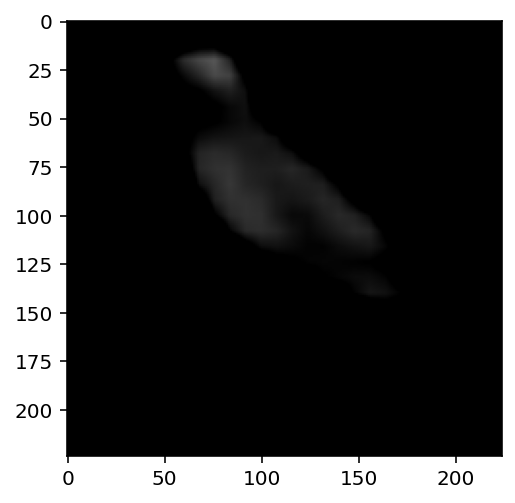

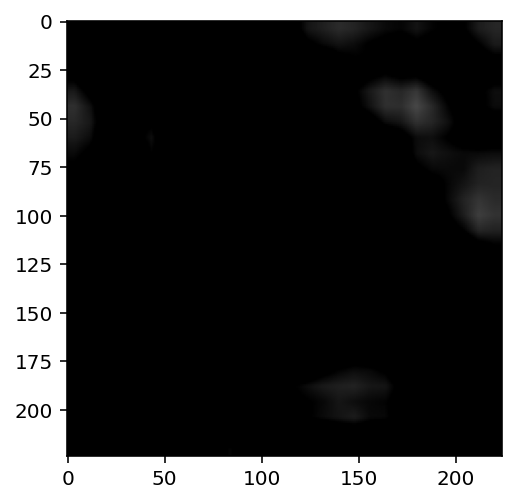

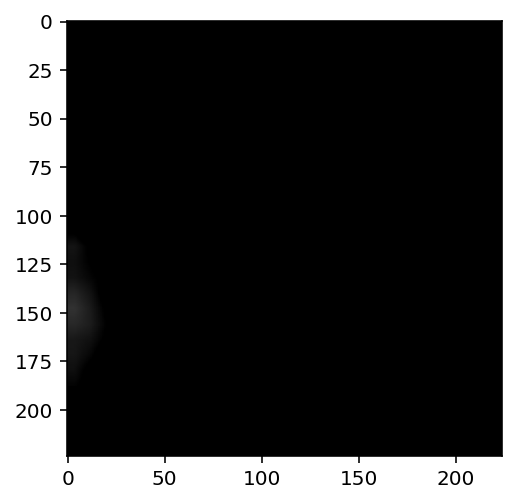

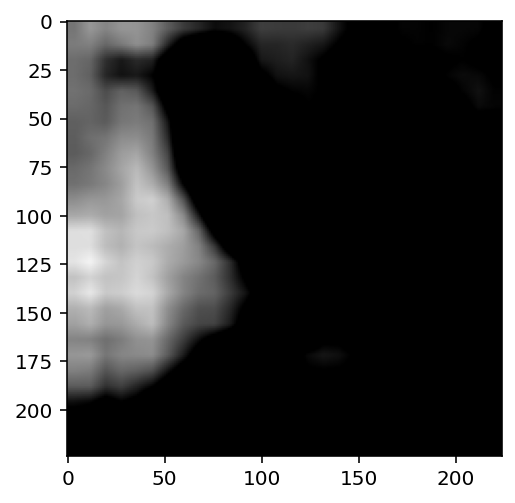

In [77]:
num_out = out.detach().numpy() * 100
print(type(num_out),num_out.shape)
num_out2 = num_out.squeeze()
print(type(num_out2),num_out2.shape)
for i in range(21):
    img1 = Image.fromarray(num_out2[i,:,:])
    plt.imshow(img1)
    plt.show()

In [9]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(224, 224)
[0 3]


In [59]:
# Define the helper function
def decode_segmap(image, nc=21):
  
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
  
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    
    rgb = np.stack([r, g, b], axis=2)
    return rgb

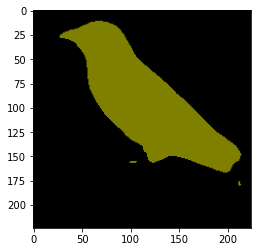

In [12]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

In [62]:
def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()

In [63]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to C:\Users\JCdata/.cache\torch\hub\checkpoints\deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

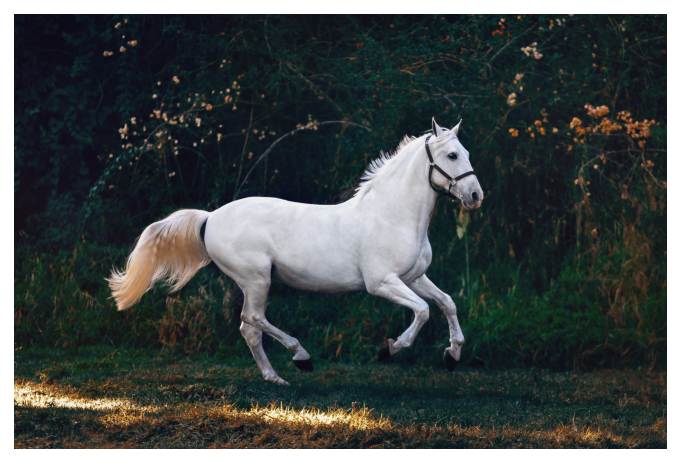

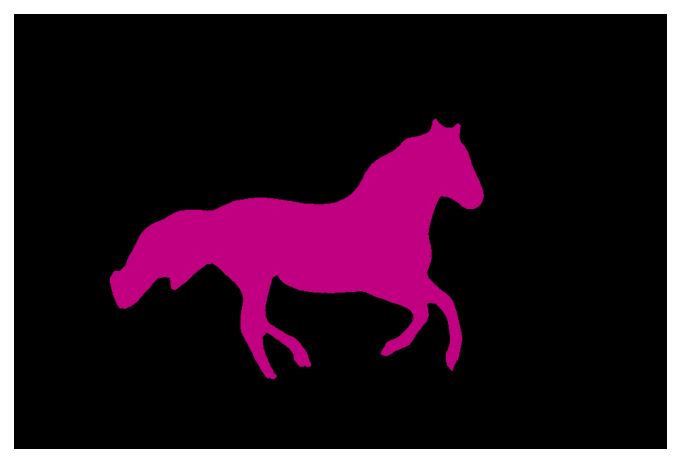

In [64]:
segment(dlab, './horse.png')

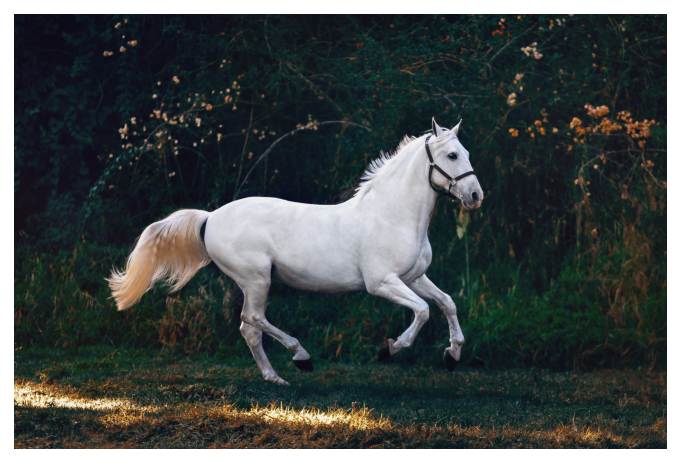

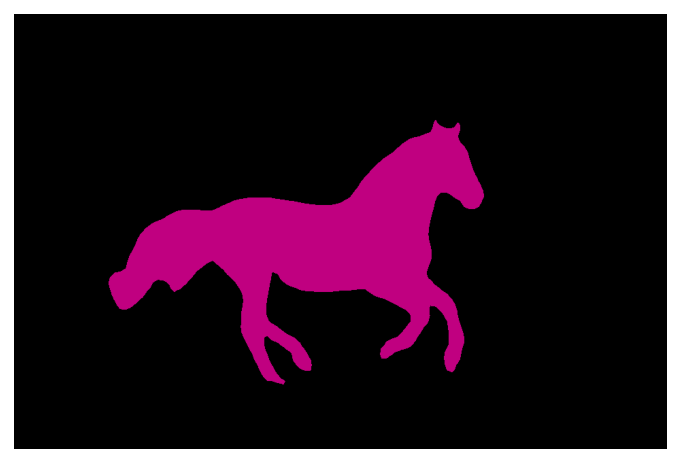

In [66]:
segment(fcn, './horse.png')

In [68]:
import time

def infer_time(net, path='./horse.png', dev='cuda'):
  img = Image.open(path)
  trf = T.Compose([T.Resize(256), 
                   T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  
  inp = trf(img).unsqueeze(0).to(dev)
  
  st = time.time()
  out1 = net.to(dev)(inp)
  et = time.time()
  
  return et - st

- time check

In [69]:
avg_over = 100

fcn_infer_time_list_cpu = [infer_time(fcn, dev='cpu') for _ in range(avg_over)]
fcn_infer_time_avg_cpu = sum(fcn_infer_time_list_cpu) / avg_over

dlab_infer_time_list_cpu = [infer_time(dlab, dev='cpu') for _ in range(avg_over)]
dlab_infer_time_avg_cpu = sum(dlab_infer_time_list_cpu) / avg_over
print ('The Average Inference time on FCN is:     {:.2f}s'.format(fcn_infer_time_avg_cpu))
print ('The Average Inference time on DeepLab is: {:.2f}s'.format(dlab_infer_time_avg_cpu))


The Average Inference time on FCN is:     0.75s
The Average Inference time on DeepLab is: 0.89s


In [70]:
avg_over = 100

fcn_infer_time_list_gpu = [infer_time(fcn) for _ in range(avg_over)]
fcn_infer_time_avg_gpu = sum(fcn_infer_time_list_gpu) / avg_over

dlab_infer_time_list_gpu = [infer_time(dlab) for _ in range(avg_over)]
dlab_infer_time_avg_gpu = sum(dlab_infer_time_list_gpu) / avg_over

print ('The Average Inference time on FCN is:     {:.3f}s'.format(fcn_infer_time_avg_gpu))
print ('The Average Inference time on DeepLab is: {:.3f}s'.format(dlab_infer_time_avg_gpu))

The Average Inference time on FCN is:     0.029s
The Average Inference time on DeepLab is: 0.031s


- Memory check

![image.png](./img/memory_check.png)